# Libraries

In [22]:
import os
import cv2
import matplotlib.pyplot as plt
import cv2

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans

# Importing and preprocessing

In [23]:
# Function to process images from a specified folder.
# Reads all images from the folder.
# Convert them from BGR to RGB format.
# Resizes them to the specified width and height.

def process_images(folder_path, width, height):
    image_paths = []
    converted_images = []
    resized_images = []

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            image_paths.append(img_path)
            image = cv2.imread(img_path)
            if image is not None:  
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                converted_images.append((filename, image_rgb))
                resized_image = cv2.resize(image_rgb, (width, height), interpolation=cv2.INTER_AREA)
                resized_images.append((filename, resized_image))
            else:
                print(f"Failed to load image: {filename}")
    return image_paths, converted_images, resized_images

In [24]:
# Function that takes an image in RGB format and a title for display

def display_image(image_data, title):
    plt.imshow(image_data)
    plt.title(title)
    plt.axis('off')  # Hide axis
    plt.show()

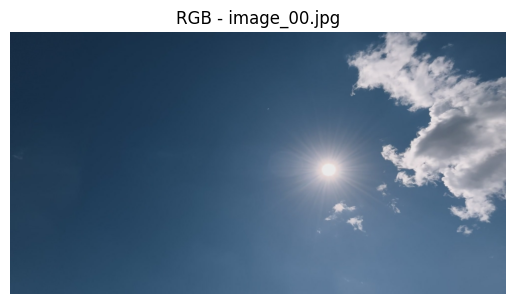

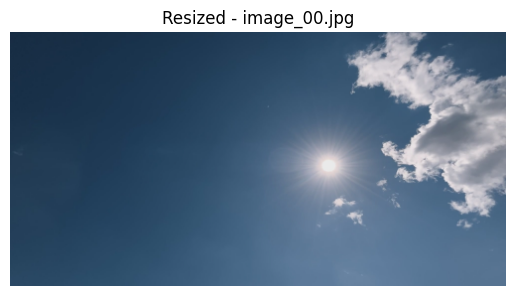

In [25]:
folder_path = r'C:\Users\berhaned\OneDrive - SINTEF\Berhane_SIN_Industri\Jupyter_Python_SINTEF\SEP_2024\Test_Repo_2024\ASI_imges'
width = 500  
height = 256  

image_paths, converted_images, resized_images = process_images(folder_path, width, height)

# Display image from the list
filename, rgb_image = converted_images[0]
display_image(rgb_image, f"RGB - {filename}")

filename, resized_image = resized_images[0]
display_image(resized_image, f"Resized - {filename}")

# RGB ratio calculation

In [26]:
def calculate_pixelwise_ratios(image_data):
    results = []

    for filename, img_rgb in image_data:
        try:
            # Extract RGB channels
            R = img_rgb[:, :, 0].astype(np.float32)
            G = img_rgb[:, :, 1].astype(np.float32)
            B = img_rgb[:, :, 2].astype(np.float32)
            
            # Avoid division by zero
            R = np.maximum(R, 1e-5)
            G = np.maximum(G, 1e-5)
            
            # Calculate B/R and B/G ratios for each pixel
            br_ratio = B / R
            bg_ratio = B / G
            
            # Sum the ratios
            combined_ratio = br_ratio + bg_ratio

            # Store the results
            results.append({'image_path': filename, 'combined_ratio': combined_ratio})

        except Exception as e:
            print(f"Error processing image {filename}: {e}")
            results.append({'image_path': filename, 'combined_ratio': None})

    return results

rgb_ratios = calculate_pixelwise_ratios(converted_images)

# KMeans clustering

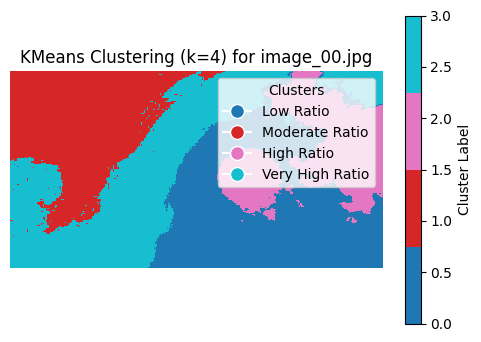

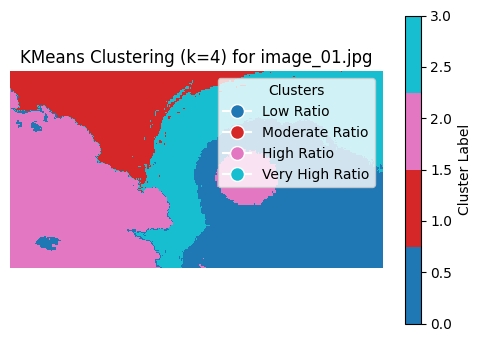

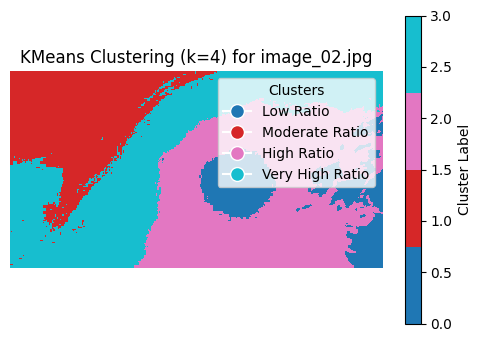

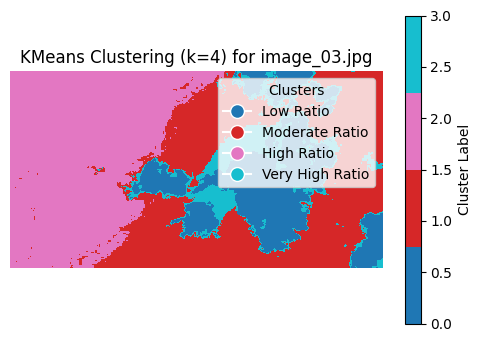

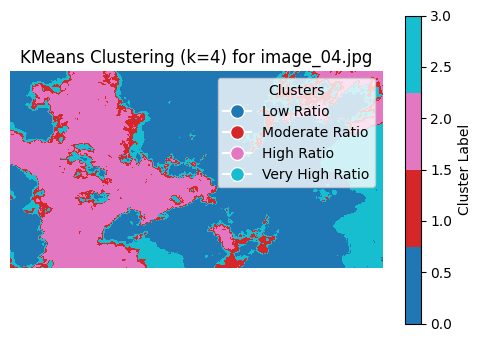

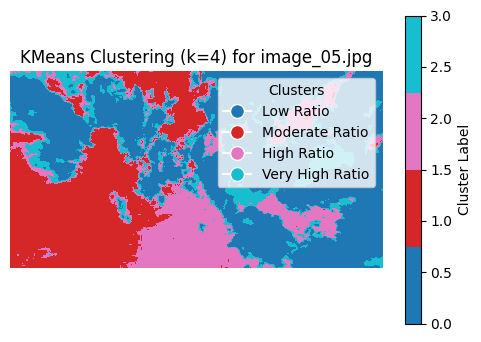

In [27]:
# Clustering based on the rgb ratio calculated above

def cluster_image_by_ratio(results, k=4):
    # Custom colormap
    custom_cmap = plt.get_cmap('tab10', k) 
    
    # Cluster definitions
    cluster_names = {0: 'Low Ratio', 1: 'Moderate Ratio', 2: 'High Ratio', 3: 'Very High Ratio'}
    
    # List to collect the rows for DataFrame
    cluster_stats_rows = []
    
    for result in results:
        image_path = result['image_path']
        combined_ratio = result['combined_ratio']
        
        if combined_ratio is not None:
            # Flatten the 2D array into a 1D array
            h, w = combined_ratio.shape
            combined_ratio_flat = combined_ratio.reshape(-1, 1)
            
            # Apply KMeans clustering
            kmeans = KMeans(n_clusters=k, random_state=0)
            labels = kmeans.fit_predict(combined_ratio_flat)
            
            # Reshape the labels to the original image dimensions
            clustered_image = labels.reshape(h, w)
            
            # Calculate mean, max, and min for each cluster
            for cluster_id in range(k):
                mask = (labels == cluster_id)
                cluster_ratios = combined_ratio_flat[mask]
                mean_val = np.mean(cluster_ratios)
                max_val = np.max(cluster_ratios)
                min_val = np.min(cluster_ratios)
                
                # Collect stats in a list of dicts
                cluster_stats_rows.append({
                    'image_path': image_path,
                    'cluster_id': cluster_id,
                    'cluster_name': cluster_names[cluster_id],  # Add descriptive name
                    'mean': mean_val,
                    'max': max_val,
                    'min': min_val
                })
            
            # Plot the clustered result
            plt.figure(figsize=(6, 4))
            plt.imshow(clustered_image, cmap=custom_cmap, interpolation='none')
            plt.title(f'KMeans Clustering (k={k}) for {image_path}')
            plt.axis('off')
            
            # Custom legend
            handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_cmap(i / k), markersize=10, label=cluster_names[i]) for i in range(k)]
            plt.legend(handles=handles, title='Clusters')
            
            plt.colorbar(label='Cluster Label')
            plt.show()
        else:
            print(f"Combined ratio for {image_path} is None")
    
    # Convert list to DataFrame
    cluster_stats_df = pd.DataFrame(cluster_stats_rows)
    
    return cluster_stats_df

# cluster information
cluster_stats_df = cluster_image_by_ratio(rgb_ratios, k=4)